# Standard Monte Carlo / Antithetic / Importace sampling with unstandardized weights / Importance sampling with standardized weights / Importance sampling with control variates

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson,uniform 
import warnings
warnings.filterwarnings("ignore")

# 6.6. Consider testing the hypotheses H0 :λ = 2 versus Ha :λ > 2 using 25 observations from a Poisson(λ) model. Rote application of the central limit theorem would suggest rejecting H0 at α = 0.05 when Z ≥ 1.645, where Z = (¯X − 2)/√2/25.

# Part a. 

# Estimate the size of this test (i.e., the type I error rate) using five Monte Carlo approaches: standard, antithetic, importance sampling with unstandardized and standardized weights, and importance sampling with a control variate as in Example 6.12. Provide a confidence interval for each estimate. Discuss the relative merits of each variance reduction technique, and compare the importance sampling strategies with each other. For the importance sampling approaches, use a Poisson envelope with mean equal to the H0 rejection threshold, namely λ = 2.4653.

In [2]:
# Initial values
num_it = 1000 # Number of iterations
num_obv = 25 # Number of observation per iteration
lambda_ = 2 # lambda = 2
h_lambda = 2.4653 # lambda for importance sampling = 2.4653

## Standard Monte Carlo

In [11]:
obv=poisson(lambda_).rvs(size=(num_it, num_obv)) # samples
x_bar = np.mean(obv,axis=1) # x_bar = sum(obv)/n
Z_s = (x_bar-lambda_)/np.sqrt(lambda_/num_obv) # Z = (x_bar-2)/sqrt(2/25) 
s_h_x = (Z_s >= 1.645).astype('uint64') # h(x) = Z > 1.645
s_mon_car_mean = np.mean(s_h_x) # mu_MC: sum(h)/n (6.1)
s_mon_car_var = np.sum((s_h_x - s_mon_car_mean)**2)/(num_it-1) # sum((h_x - mu_MC)^2)/(n-1) (6.2)
s_mon_car_std = np.sqrt(s_mon_car_var/num_it) # standard value = sigma/sqrt(num_it)
s_con_lo_bound = s_mon_car_mean - 1.96*s_mon_car_std # Confidence lower bound: low = m - 1.96std
s_con_up_bound = s_mon_car_mean + 1.96*s_mon_car_std # Confidence upper bound: up = m + 1.96std
s_conf_in = s_con_up_bound - s_con_lo_bound # Confidence interval: upper_bound - lower_bound
print('The size of the Test for the Standard Monte Carlo: ',s_mon_car_mean)
print('------------------------------------------------------------------------------------------')
print('The lower bound of the confidence interval for the Standard Monte Carlo: ', s_con_lo_bound)
print('------------------------------------------------------------------------------------------')
print('The upper bound of the confidence interval for the Standard Monte Carlo: ', s_con_up_bound)
print('------------------------------------------------------------------------------------------')
print('The length of Confidence Interval for the Standard Monte Calro: ',s_conf_in)

The size of the Test for the Standard Monte Carlo:  0.056
------------------------------------------------------------------------------------------
The lower bound of the confidence interval for the Standard Monte Carlo:  0.04174217309587369
------------------------------------------------------------------------------------------
The upper bound of the confidence interval for the Standard Monte Carlo:  0.07025782690412631
------------------------------------------------------------------------------------------
The length of Confidence Interval for the Standard Monte Calro:  0.02851565380825262


## Antithetic

In [12]:
uni_sample_1 = uniform().rvs(size=(num_obv,num_it)) # i.i.d unif(0,1) random variables
uni_sample_2 = 1 - uni_sample_1 # i.i.d unif(0,1) random variables
mu_1 = poisson.ppf(uni_sample_1,lambda_) # cumulative distribution function
mu_2 = poisson.ppf(uni_sample_2,lambda_) # cumulative distribution function
x_bar_1 = np.mean(mu_1,axis=0) # x_bar = sum(obv)/n
x_bar_2 = np.mean(mu_2,axis=0) # x_bar = sum(obv)/n
Z_a_1 = (x_bar_1 - lambda_)/np.sqrt(lambda_/num_obv) # Z = (x_bar-2)/sqrt(2/25) 
Z_a_2 = (x_bar_2 - lambda_)/np.sqrt(lambda_/num_obv) # Z = (x_bar-2)/sqrt(2/25)
h_1 = (Z_a_1 >= 1.645) # h(x) = Z > 1.645
h_2 = (Z_a_2 >= 1.645) # h(x) = Z > 1.645
ant_mon_car_mean = 0.5*(np.mean(h_1) + np.mean(h_2)) # Antithetic estimator: mu_AS = 0.5(mu_1 + mu_2) (6.57)
rho = np.corrcoef(h_1,h_2) # Covariance matrix 
rho = rho[0,1] # correlation between the two estimator
ant_mon_car_var = (1+rho)*np.var(h_1)/(2*num_it) # Antithetic variance: var_AS = (1+rho)sigma_2/2n (6.58)
ant_mon_car_std = np.sqrt(ant_mon_car_var/num_it) # standard value = sigma/sqrt(num_it)
ant_con_lo_bound = ant_mon_car_mean - 1.96*ant_mon_car_std # Confidence lower bound: low = m - 1.96std
ant_con_up_bound = ant_mon_car_mean + 1.96*ant_mon_car_std # Confidence upper bound: up = m + 1.96std
ant_conf_in = ant_con_up_bound - ant_con_lo_bound # Confidence interval: upper_bound - lower_bound
print('The size of the Test for the Antithetic Monte Carlo: ',ant_mon_car_mean)
print('------------------------------------------------------------------------------------------')
print('The lower bound of the confidence interval for Antithetic Monte Carlo:', ant_con_lo_bound)
print('------------------------------------------------------------------------------------------')
print('The upper bound of the confidence interval for Antithetic Monte Carlo:', ant_con_up_bound)
print('------------------------------------------------------------------------------------------')
print('The length of Confidence Interval for the Antithetic Monte Calro:',ant_conf_in)

The size of the Test for the Antithetic Monte Carlo:  0.0535
------------------------------------------------------------------------------------------
The lower bound of the confidence interval for Antithetic Monte Carlo: 0.05319047148077717
------------------------------------------------------------------------------------------
The upper bound of the confidence interval for Antithetic Monte Carlo: 0.05380952851922283
------------------------------------------------------------------------------------------
The length of Confidence Interval for the Antithetic Monte Calro: 0.0006190570384456556


## Importace sampling with unstandardized weights

In [15]:
h_obv = poisson(h_lambda).rvs(size=(num_obv,num_it)) # samples
wei_is_un =  np.prod(poisson.pmf(h_obv,lambda_)/poisson.pmf(h_obv,h_lambda),axis=0) # unstandardized weights w* = f/g 
x_bar_is_un = np.mean(obv,axis=1) # x_bar = sum(obv)/n
Z_is_un = (x_bar_is_un - lambda_)/np.sqrt(lambda_/num_obv) # Z = (x_bar-2)/sqrt(2/25)
h_is_un = (Z_is_un >= 1.645).astype('uint64') # h(x) = Z > 1.645
is_un_mon_car_mean = np.mean(h_is_un*wei_is_un) # IS Unstand. mean: sum(h.w*)/n (6.38)
is_un_mon_car_var = np.var(h_is_un*wei_is_un) # IS Unstand. var = sum((w.h(x) - mu_IS)^2)/n
is_un_mon_car_std = np.sqrt(is_un_mon_car_var/num_it**2) # IS Unstand. std: var(h.w*)/n (6.41)
is_un_con_lo_bound = is_un_mon_car_mean - 1.96*is_un_mon_car_std # Confidence lower bound: low = m - 1.96std
is_un_con_up_bound = is_un_mon_car_mean + 1.96*is_un_mon_car_std # Confidence upper bound: up = m + 1.96std
is_un_conf_in = is_un_con_up_bound - is_un_con_lo_bound # Confidence interval: upper_bound - lower_bound
print('The size of the Test for the IS with Unstandardized Monte Carlo:',is_un_mon_car_mean)
print('------------------------------------------------------------------------------------------')
print('The lower bound of the confidence interval for IS with unstandardized weights: ', is_un_con_lo_bound)
print('------------------------------------------------------------------------------------------')
print('The upper bound of the confidence interval for IS with unstandardized weights: ', is_un_con_up_bound)
print('------------------------------------------------------------------------------------------')
print('The length of Confidence Interval for the IS with Unstandardized Monte Calro: ',is_un_conf_in)

The size of the Test for the IS with Unstandardized Monte Carlo: 0.06230204813398715
------------------------------------------------------------------------------------------
The lower bound of the confidence interval for IS with unstandardized weights:  0.06101969445378209
------------------------------------------------------------------------------------------
The upper bound of the confidence interval for IS with unstandardized weights:  0.06358440181419223
------------------------------------------------------------------------------------------
The length of Confidence Interval for the IS with Unstandardized Monte Calro:  0.0025647073604101386


## Importance sampling with standardized weights


In [20]:
h_obv = poisson(h_lambda).rvs(size=(num_obv,num_it)) # samples
wei_is = np.prod(poisson.pmf(h_obv,lambda_)/poisson.pmf(h_obv,h_lambda),axis=0) # unstandardized weights w* = f/g  
x_bar_is = np.mean(obv,axis=1) # x_bar = sum(obv)/n
Z_is = (x_bar_is - lambda_)/np.sqrt(lambda_/num_obv) # Z = (x_bar-2)/sqrt(2/25)
h_is = (Z_is >= 1.645).astype('uint64') # h(x) = Z > 1.645
w_star = wei_is # w* <-- Unstand. weights
wei_is = wei_is/np.sum(wei_is) # IS Stand. wieghts: w = w*/sum(w*)
is_mon_car_mean = np.sum(wei_is*h_is) # IS Stand. mean: sum(h.w) (6.39) 
is_mon_car_var = np.sum(wei_is**2*(h_is - is_mon_car_mean)**2) # estimation of var = sum(w^2*(h(x) - mu_IS)^2)
is_mon_car_std = np.sqrt(is_mon_car_var/num_it) # IS Stand. std: var/n 
is_con_lo_bound = is_mon_car_mean - 1.96*is_mon_car_std # Confidence lower bound: low = m - 1.96std 
is_con_up_bound = is_mon_car_mean + 1.96*is_mon_car_std # Confidence upper bound: up = m + 1.96std
is_conf_in = is_con_up_bound - is_con_lo_bound # Confidence interval: upper_bound - lower_bound
print('The size of the Test for the IS with Standardized Monte Carlo: ',is_mon_car_mean)
print('------------------------------------------------------------------------------------------')
print('The lower bound of the confidence interval for IS with standardized weights: ', is_con_lo_bound)
print('------------------------------------------------------------------------------------------')
print('The upper bound of the confidence interval for IS with standardized weights: ', is_con_up_bound)
print('------------------------------------------------------------------------------------------')
print('The length of Confidence Interval for the IS with Standardized Monte Calro: ',is_conf_in)

The size of the Test for the IS with Standardized Monte Carlo:  0.06191592238044602
------------------------------------------------------------------------------------------
The lower bound of the confidence interval for IS with standardized weights:  0.06092661634113613
------------------------------------------------------------------------------------------
The upper bound of the confidence interval for IS with standardized weights:  0.06290522841975592
------------------------------------------------------------------------------------------
The length of Confidence Interval for the IS with Standardized Monte Calro:  0.001978612078619789


## Importance sampling with control variates

In [21]:
theta = w_star
theta_mon_car_var = np.var(theta) # var of theta_mc = var(h.w)
cv_cov = np.cov(h_is*w_star,theta) # correlation between theta(y) and h(x) 
cv_lambda = -cv_cov[0,1]/theta_mon_car_var # lambda = -cov(mu_MC,theta_MC)/var(theta_MC) (6.69)
cv_mon_car_var = is_mon_car_var
IS_mon_car_mean = np.sum(wei_is*h_is) # mu_MC in (6.66) 
cv_mean = IS_mon_car_mean + cv_lambda*(np.mean(w_star) - 1) # CV mean: mu_MC_IS + lambda(w_bar - 1) (6.72)
cv_mon_car_std = np.sqrt(cv_mon_car_var/num_it) # IS CV. std: var/n 
cv_con_lo_bound = cv_mean - 1.96*cv_mon_car_std # Confidence lower bound: low = m - 1.96std 
cv_con_up_bound = cv_mean + 1.96*cv_mon_car_std # Confidence upper bound: up = m + 1.96std
cv_conf_in = cv_con_up_bound - cv_con_lo_bound # Confidence interval: upper_bound - lower_bound
print('The size of the Test for the IS with Control Variates Monte Carlo: ',cv_mean)
print('------------------------------------------------------------------------------------------')
print('The lower bound of the confidence interval for IS with Control Variates: ', cv_con_lo_bound)
print('------------------------------------------------------------------------------------------')
print('The upper bound of the confidence interval for IS with Control Variates: ', cv_con_up_bound)
print('------------------------------------------------------------------------------------------')
print('The length of Confidence Interval for the IS with Control Variates Monte Calro: ',cv_conf_in)

The size of the Test for the IS with Control Variates Monte Carlo:  0.06346472946481542
------------------------------------------------------------------------------------------
The lower bound of the confidence interval for IS with Control Variates:  0.06247542342550553
------------------------------------------------------------------------------------------
The upper bound of the confidence interval for IS with Control Variates:  0.06445403550412532
------------------------------------------------------------------------------------------
The length of Confidence Interval for the IS with Control Variates Monte Calro:  0.001978612078619789


## Discussion

### Regarding these results, the standard Monte Carlo has the biggest lenght. That is, it has the least precision. On the other hand, Antithetic method achieves the lowest lenght which means it has the highest precision.

### The performance of the important sampling strategies are close.

# Part b.

# Draw the power curve for this test for λ ∈ [2.2, 4], using the same five techniques. Provide pointwise confidence bands in each case. Discuss the relative merits of each technique in this setting. Compare the performances of the importance sampling strategies with their performance in part (a).

## Standard monte carlo

In [56]:
lambda_range = np.linspace(2.2,4,100) # lambda = [2.2,4]
power_s=[]
s_con_lo_bound=[]
s_con_up_bound=[]
s_conf_in=[]
for ii in range (len(lambda_range)):
    st_obv = poisson(lambda_range[ii]).rvs(size=(num_obv,num_it)) # generate observation 
    x_bar_st = np.mean(st_obv,axis=0) # x_bar = sum(obv)/n
    Z_s = (x_bar_st - lambda_)/np.sqrt(lambda_/num_obv) # Z = (x_bar - 2)/sqrt(2/25)
    s_h_x = (Z_s >= 1.645).astype('uint64') # h(x) = Z > 1.645
    power_s.append(np.sum(s_h_x)) # Z > 1.645
    s_mon_car_mean = np.sum(s_h_x)/num_it # mu_MC: sum(h)/n (6.47) 
    s_mon_car_var = np.sum((s_h_x - s_mon_car_mean)**2)/(num_it-1) # sum((h_x - mu_MC)^2)/(n-1) (6.2)
    s_mon_car_std = np.sqrt(s_mon_car_var/num_it) # standard value = sigma/sqrt(num_it)
    s_con_lo_bound.append(s_mon_car_mean - 1.96*s_mon_car_std) # Confidence lower bound: low = m - 1.96std 
    s_con_up_bound.append(s_mon_car_mean + 1.96*s_mon_car_std) # Confidence interval: upper_bound - lower_bound
    s_conf_in.append((s_mon_car_mean + 1.96*s_mon_car_std)-(s_mon_car_mean - 1.96*s_mon_car_std)) # Confidence interval: upper_bound - lower_bound

In [57]:
power_s = np.array(power_s)/num_it # normalize the power

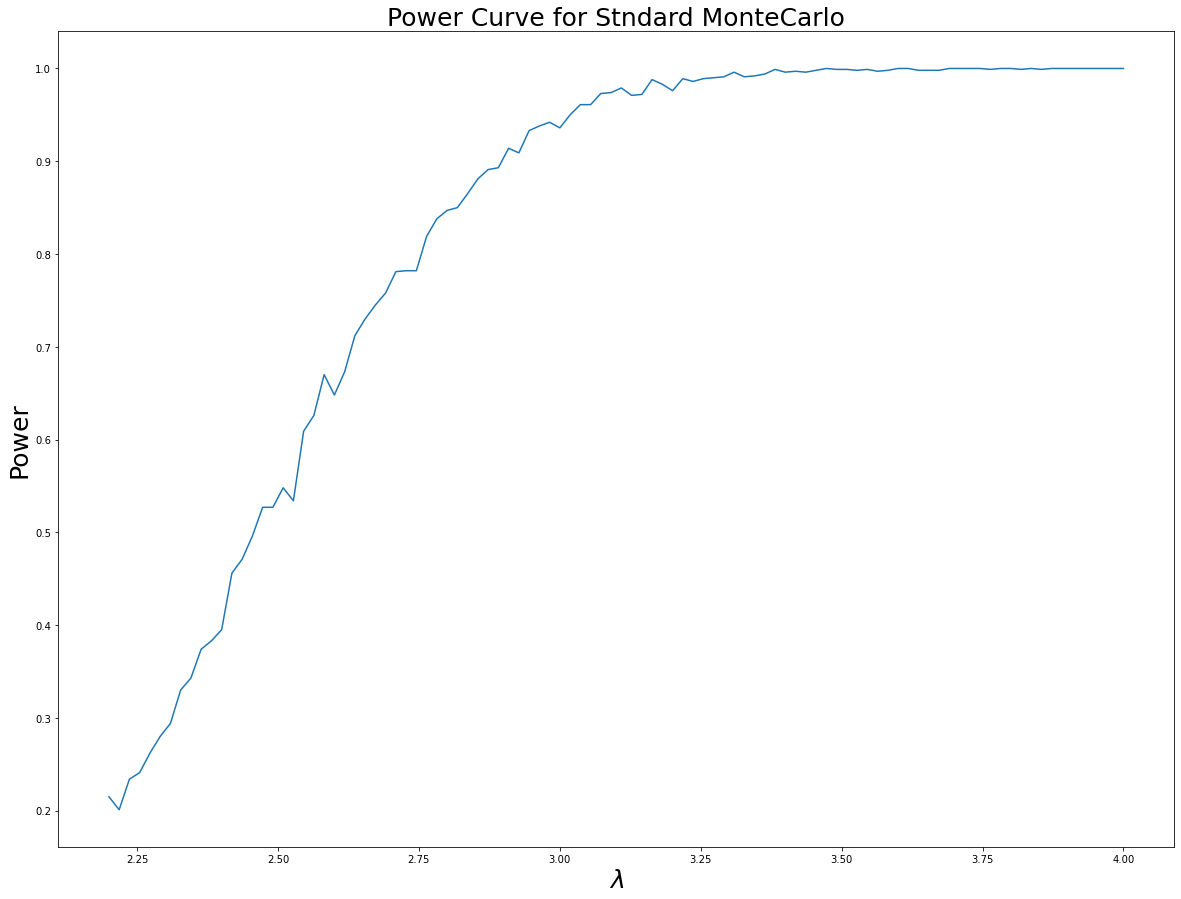

In [58]:
plt.figure(figsize=(20,15))
plt.plot(lambda_range,power_s) # plot power vs lambda in range of [2.2,4]
plt.title('Power Curve for Stndard MonteCarlo',fontsize=25)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Power',fontsize=25)
plt.show()

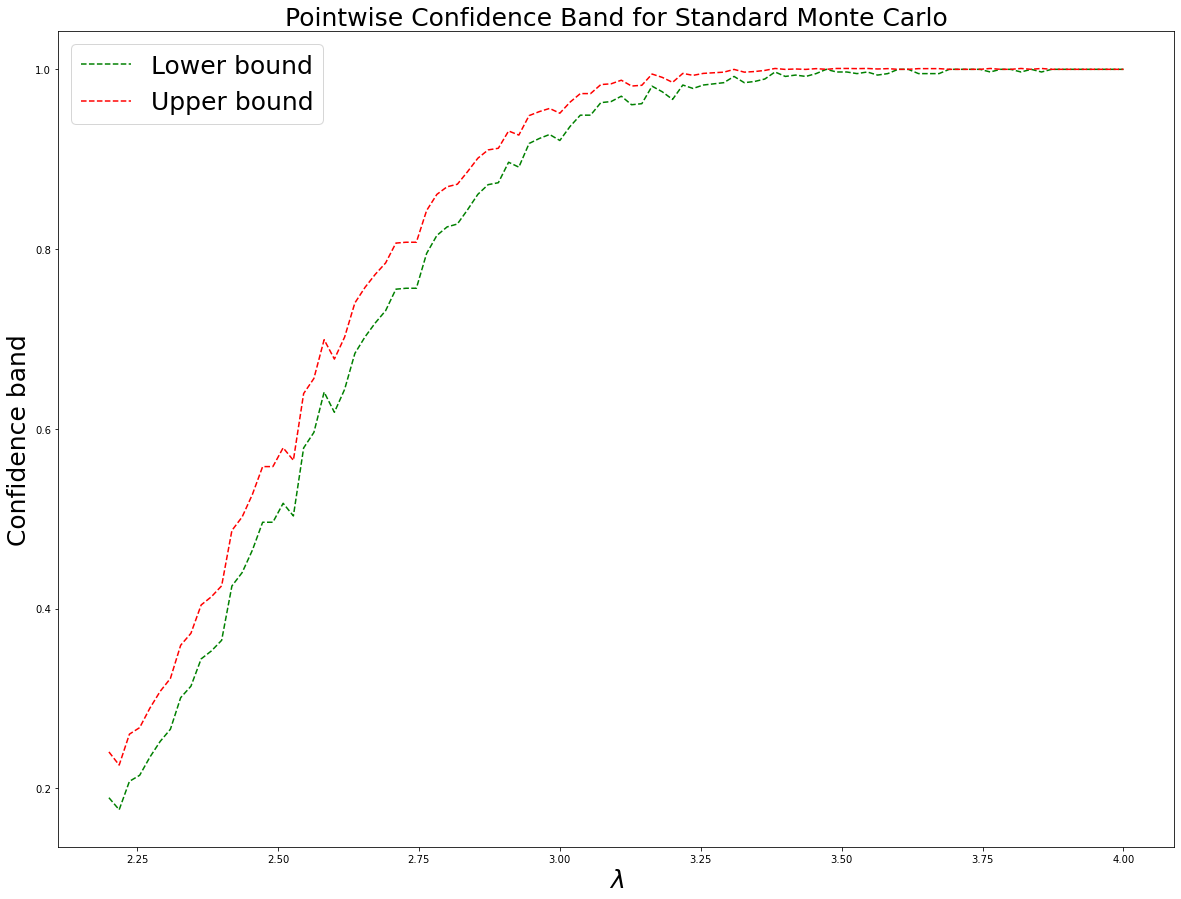

In [59]:
plt.figure(figsize=(20,15))
plt.plot(lambda_range,s_con_lo_bound,'g--',label='Lower bound') # plot the lower bound 
plt.plot(lambda_range,s_con_up_bound,'r--',label='Upper bound'); # plot the upper bound
plt.title('Pointwise Confidence Band for Standard Monte Carlo',fontsize=25)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Confidence band',fontsize=25)
plt.legend(fontsize=25)
plt.show()

## Antithetic sampling

In [60]:
lambda_range = np.linspace(2.2,4,100) # lambda = [2.2,4]
power_ant = []
ant_con_lo_bound = []
ant_con_up_bound = []
for ii in range (len(lambda_range)):
    uni_sample_1 = uniform().rvs(size=(num_obv,num_it)) #i.i.d unif(0,1) random variables
    uni_sample_2 = 1 - uni_sample_1 # i.i.d unif(0,1) random variables
    mu_1 = poisson.ppf(uni_sample_1,lambda_range[ii]) # cumulative distribution function
    mu_2 = poisson.ppf(uni_sample_2,lambda_range[ii]) # cumulative distribution function
    x_bar_1 = np.mean(mu_1,axis=0) # x_bar = sum(obv)/n
    x_bar_2 = np.mean(mu_2,axis=0) # x_bar = sum(obv)/n
    Z_a_1 = (x_bar_1 - lambda_)/np.sqrt(lambda_/num_obv) # Z = (x_bar-2)/sqrt(2/25) 
    Z_a_2 = (x_bar_2 - lambda_)/np.sqrt(lambda_/num_obv) # Z = (x_bar-2)/sqrt(2/25)
    h_1 = (Z_a_1 >= 1.645) # h(x) = Z > 1.645
    h_2 = (Z_a_2 >= 1.645) # h(x) = Z > 1.645
    ant_mon_car_mean = 0.5*(np.mean(h_1) + np.mean(h_2)) # Antithetic estimator: mu_AS = 0.5(mu_1 + mu_2) (6.57)
    rho = np.corrcoef(h_1,h_2) # Covariance matrix 
    rho = rho[0,1] # correlation between the two estimator
    power_ant.append(ant_mon_car_mean) # power of Antithetic
    ant_mon_car_var = (1+rho)*np.var(h_1)/(2*num_it) # Antithetic variance: var_AS = (1+rho)sigma_2/2n (6.58)
    ant_mon_car_std = np.sqrt(ant_mon_car_var/num_it) # standard value = sigma/sqrt(num_it)
    ant_con_lo_bound.append(ant_mon_car_mean - 1.96*ant_mon_car_std) # Confidence interval: upper_bound - lower_bound 
    ant_con_up_bound.append(ant_mon_car_mean + 1.96*ant_mon_car_std) # Confidence interval: upper_bound - lower_bound

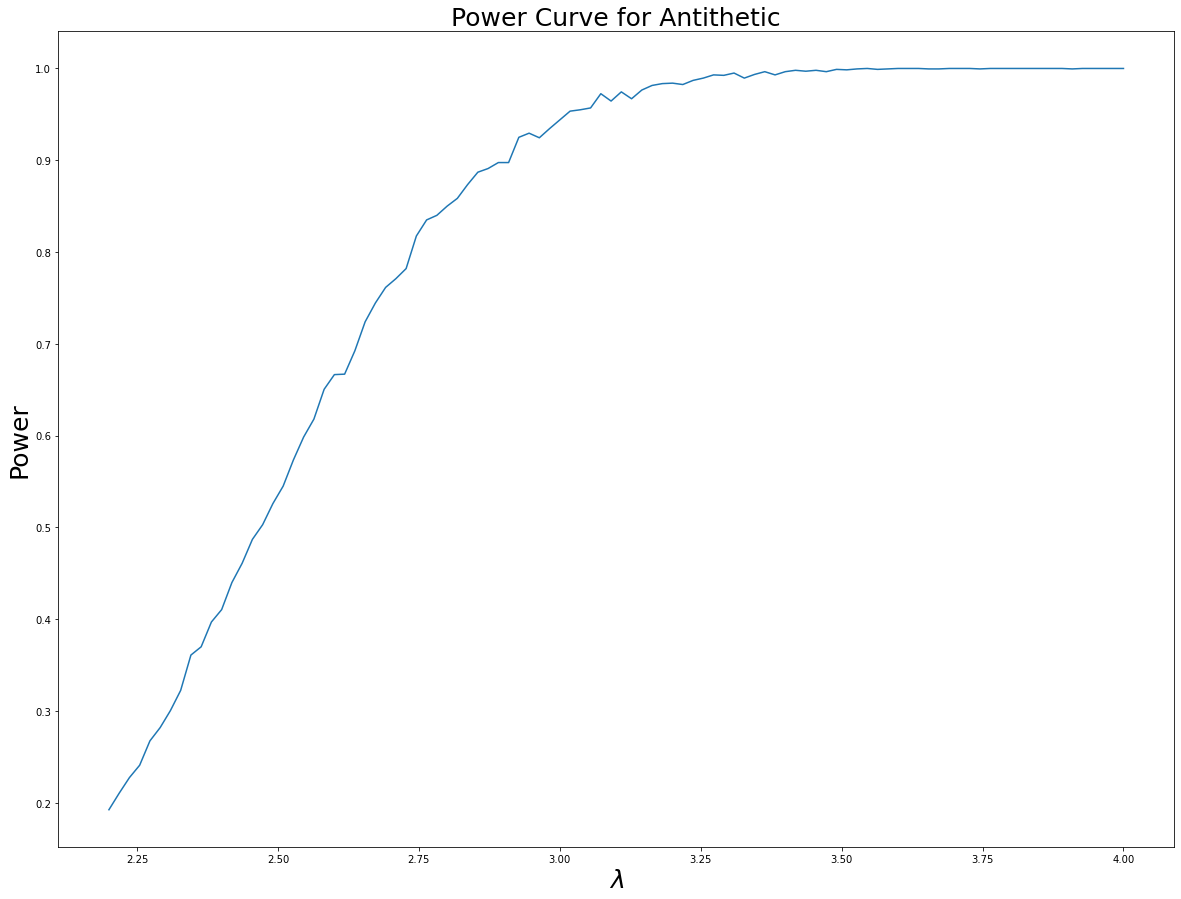

In [61]:
plt.figure(figsize=(20,15))
plt.plot(lambda_range,power_ant) # plot power vs lambda in range of [2.2,4]
plt.title('Power Curve for Antithetic',fontsize=25)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Power',fontsize=25)
plt.show()

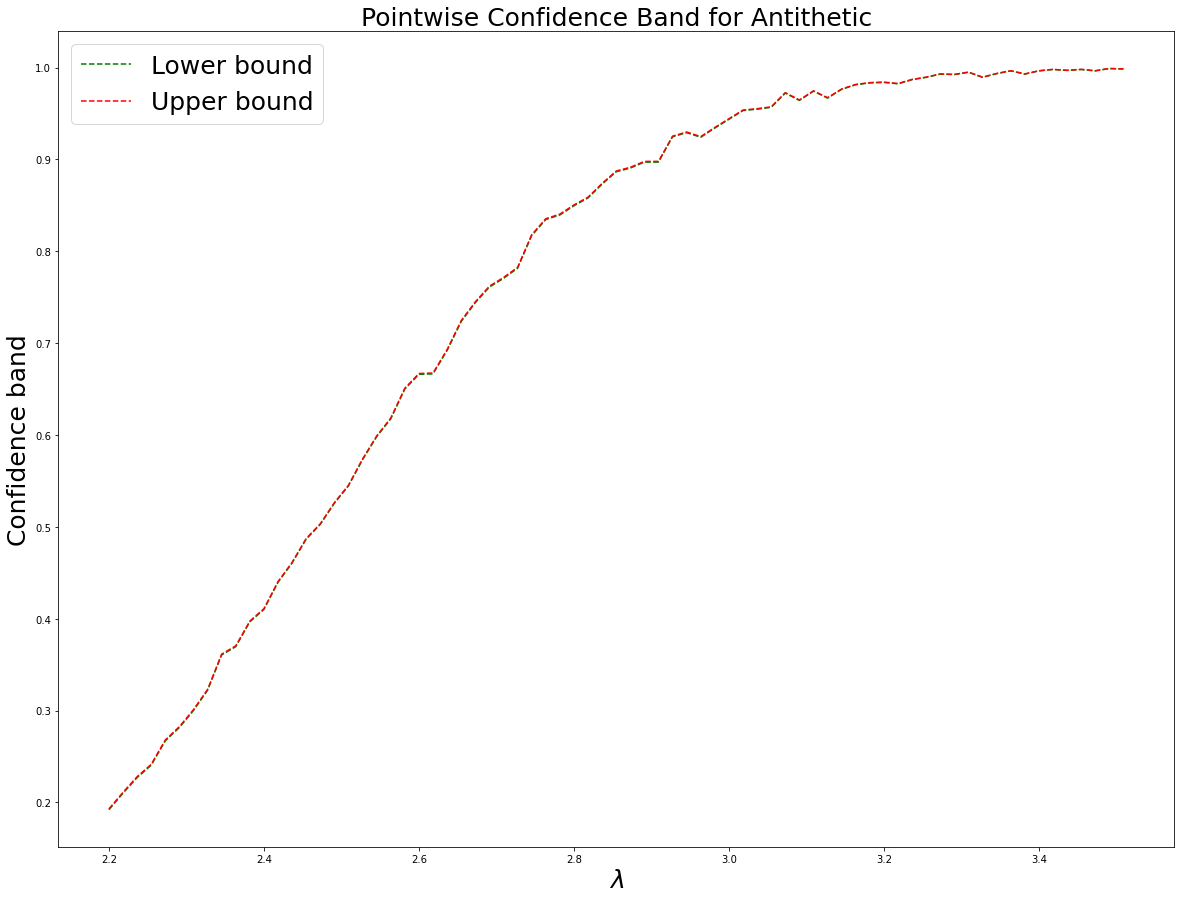

In [62]:
plt.figure(figsize=(20,15))
plt.plot(lambda_range,ant_con_lo_bound,'g--',label='Lower bound') # plot the lower bound 
plt.plot(lambda_range,ant_con_up_bound,'r--',label='Upper bound'); # plot the upper bound
plt.title('Pointwise Confidence Band for Antithetic',fontsize=25)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Confidence band',fontsize=25)
plt.legend(fontsize=25)
plt.show()

## Importance Sampling with Unstandardized Weights

In [73]:
lambda_range = np.linspace(2.2,4,100) # lambda = [2.2,4]
power_is_un = []
is_un_con_lo_bound = []
is_un_con_up_bound = []
for ii in range (len(lambda_range)):
    is_un_obv = poisson(lambda_range[ii]).rvs(size=(num_obv,num_it))# generate observation
    h_obv = poisson(h_lambda).rvs(size=(num_obv,num_it)) # samples
    wei_is_un =  np.prod(poisson.pmf(h_obv,lambda_range[ii])/poisson.pmf(h_obv,h_lambda),axis=0) # unstandardized weights w* = f/g 
    wei_is_un = wei_is_un/np.mean(wei_is_un)
    x_bar_is_un = np.mean(is_un_obv,axis=0) # x_bar = sum(obv)/n
    Z_is_un = (x_bar_is_un - lambda_)/np.sqrt(lambda_/num_obv) # Z = (x_bar-2)/sqrt(2/25) 
    h_is_un = (Z_is_un >= 1.645).astype('uint64') # Z >= 1.645
    is_un_mon_car_mean = np.mean(h_is_un*wei_is_un) # IS Unstand. mean: sum(h.w*)/n (6.40)
    power_is_un.append(np.mean(h_is_un)) # power of IS Unstand.
    is_un_mon_car_std = np.sqrt(np.var(h_is_un*wei_is_un)/num_it**2) # IS Unstand. var and std: var(h.w*)/n (6.41)
    is_un_con_lo_bound.append(is_un_mon_car_mean - 1.96*is_un_mon_car_std) # Confidence interval: upper_bound - lower_bound 
    is_un_con_up_bound.append(is_un_mon_car_mean + 1.96*is_un_mon_car_std) # Confidence interval: upper_bound - lower_bound

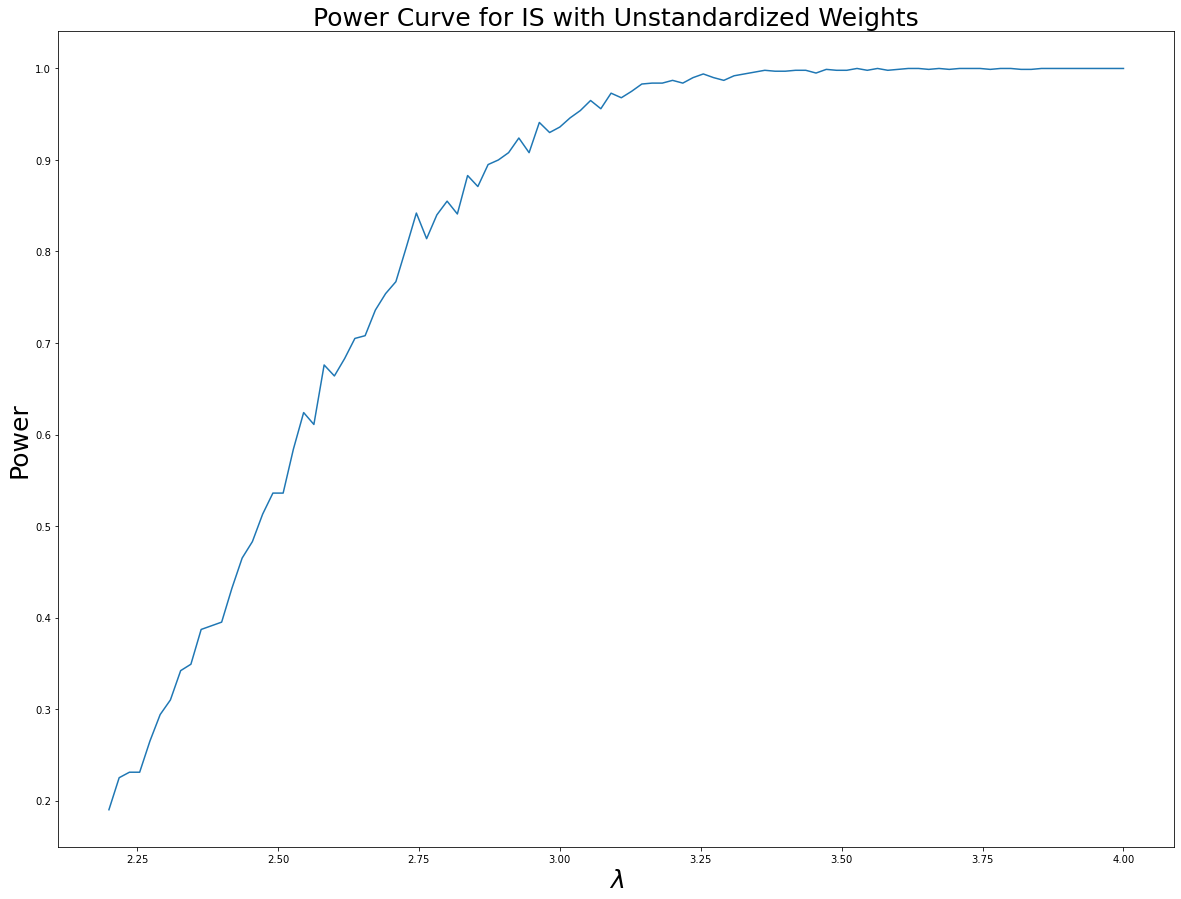

In [74]:
plt.figure(figsize=(20,15))
plt.plot(lambda_range,power_is_un) # plot power vs lambda in range of [2.2,4]
plt.title('Power Curve for IS with Unstandardized Weights',fontsize=25)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Power',fontsize=25)
plt.show()

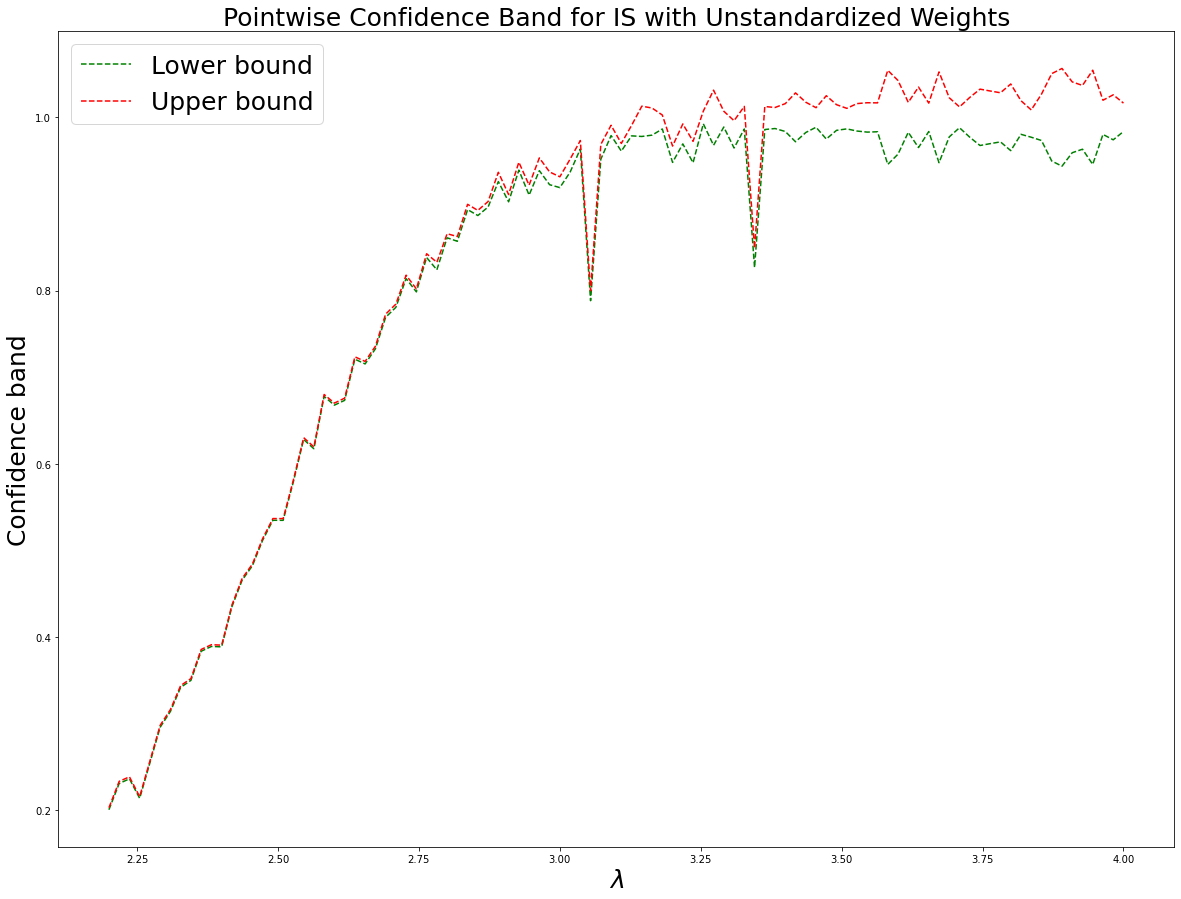

In [76]:
plt.figure(figsize=(20,15))
plt.plot(lambda_range,is_un_con_lo_bound,'g--',label='Lower bound') # plot the lower bound 
plt.plot(lambda_range,is_un_con_up_bound,'r--',label='Upper bound'); # plot the upper bound
plt.title('Pointwise Confidence Band for IS with Unstandardized Weights',fontsize=25)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Confidence band',fontsize=25)
plt.legend(fontsize=25)
plt.show()

## Importance Sampling with Standardized Weights

In [70]:
lambda_range = np.linspace(2.2,4,100) # lambda = [2.2,4]
power_is = []
is_con_lo_bound = []
is_con_up_bound = []
for ii in range (len(lambda_range)):
    is_obv = poisson(lambda_range[ii]).rvs(size=(num_obv,num_it)) # generate observation 
    h_obv = poisson(h_lambda).rvs(size=(num_obv,num_it)) # samples
    wei_is = np.prod(poisson.pmf(h_obv,lambda_range[ii])/poisson.pmf(h_obv,h_lambda),axis=0) # IS Stand. wieghts: w = w*/sum(w*)
    x_bar_is = np.mean(is_obv,axis=0) # x_bar = sum(obv)/n
    Z_is = (x_bar_is - lambda_)/np.sqrt(lambda_/num_obv) # Z = (x_bar-2)/sqrt(2/25) 
    h_is = (Z_is >= 1.645).astype('uint64') # Z > 1.645
    w_star = wei_is # w* <-- Unstand. weights
    wei_is_norm = wei_is/np.sum(wei_is) # IS Stand. wieghts: w = w*/sum(w*)
    power_is.append(np.mean(h_is)) # power of IS Stand.
    is_mon_car_mean = np.sum(wei_is_norm*h_is) # IS Stand. mean: sum(h.w) (6.39) 
    is_cor = np.cov(h_is*w_star,w_star) # correlation matrix
    is_cov = is_cor[0,1] # correlation between h.w* and w*   
    is_mon_car_var = (np.var(h_is*w_star) + np.mean(h_is*w_star)**2*np.var(w_star) - 2*np.mean(h_is*w_star)*is_cov)/num_it # IS Stand. var: (var(h.w*) + mu^2.var(w*)-2mu.cov(h.w*,w*))/n (6.43)
    is_mon_car_std = np.sqrt(is_mon_car_var/num_it) # IS Stand. std: var/n 
    is_con_lo_bound.append(is_mon_car_mean - 1.96*is_mon_car_std) # Confidence interval: upper_bound - lower_bound 
    is_con_up_bound.append(is_mon_car_mean + 1.96*is_mon_car_std) # Confidence interval: upper_bound - lower_bound

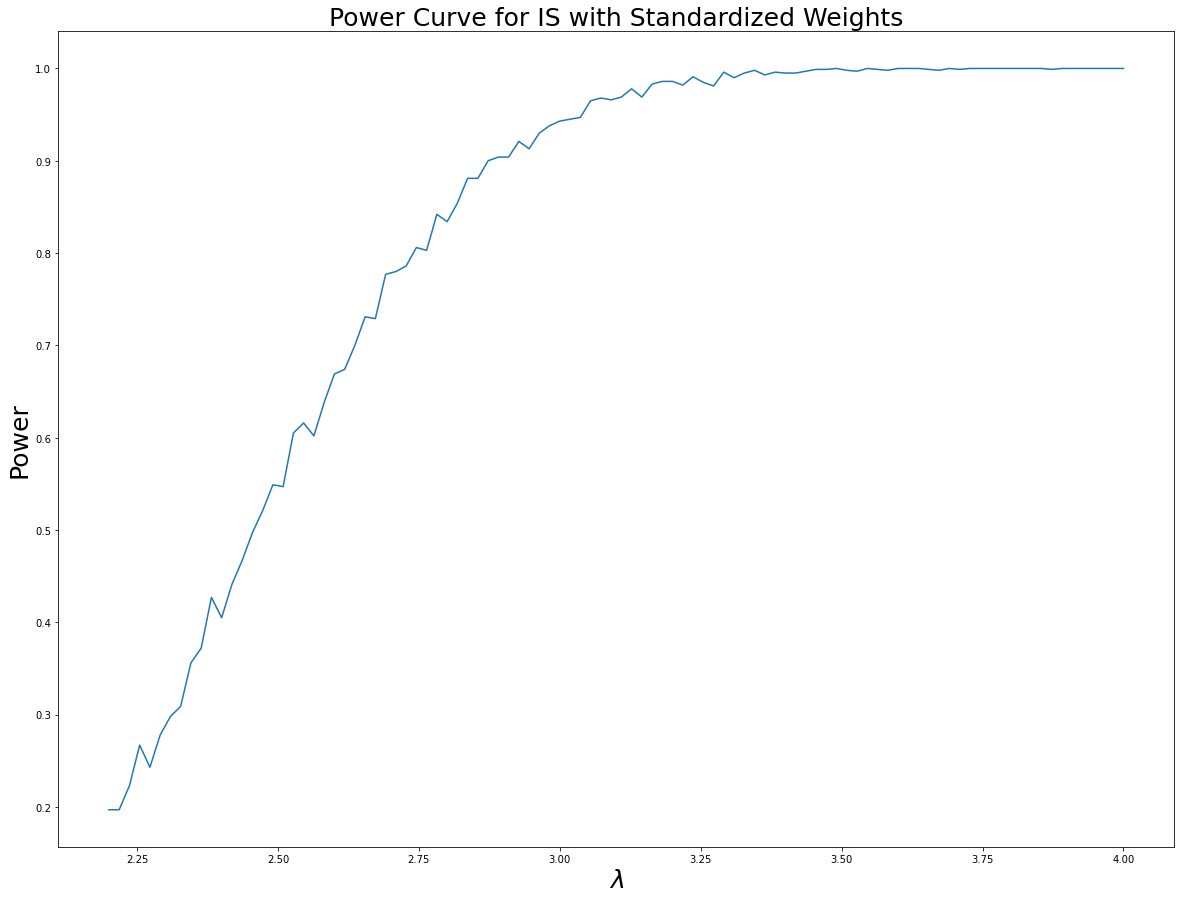

In [71]:
plt.figure(figsize=(20,15))
plt.plot(lambda_range,power_is) # plot power vs lambda in range of [2.2,4]
plt.title('Power Curve for IS with Standardized Weights',fontsize=25)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Power',fontsize=25)
plt.show()

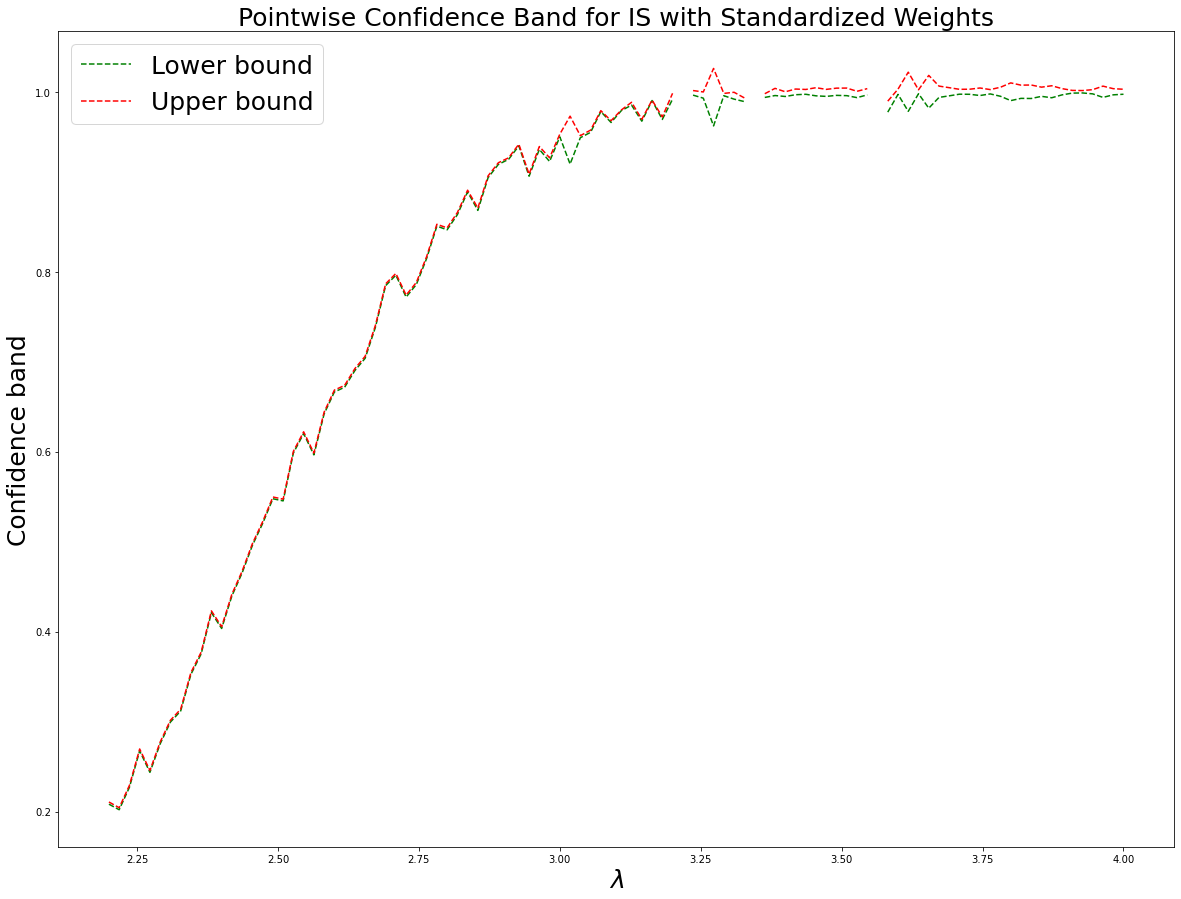

In [72]:
plt.figure(figsize=(20,15))
plt.plot(lambda_range,is_con_lo_bound,'g--',label='Lower bound') # plot the lower bound 
plt.plot(lambda_range,is_con_up_bound,'r--',label='Upper bound'); # plot the upper bound
plt.title('Pointwise Confidence Band for IS with Standardized Weights',fontsize=25)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Confidence band',fontsize=25)
plt.legend(fontsize=25)
plt.show()

## Control Variates

In [ ]:
lambda_range = linspace(2.2,4); % lambda = [2.2,4]
for ii = 1:length(lambda_range)
    cv_obv = poissrnd(lambda_range(ii),num_obv,num_it);
    h_obv = poissrnd(h_lambda,num_obv,num_it);
    wei_cv = prod(poisspdf(h_obv,lambda_range(ii))./poisspdf(h_obv,h_lambda));
    wei_cv = wei_cv./mean(wei_cv);
    x_bar_cv = mean(cv_obv); % x_bar = sum(obv)/n
    Z_cv = (x_bar_cv - lambda)/sqrt(lambda/num_obv); % Z = (x_bar-2)/sqrt(2/25) 
    h_cv = (Z_cv >= 1.645); % Z > 1.645
    w_star = wei_cv; % w* <-- Unstand. weights
    wei_cv = wei_cv/sum(wei_cv); % IS Stand. wieghts: w = w*/sum(w*)
    cv_mean = sum(wei_cv.*h_cv); % IS Stand. mean: sum(h.w) (6.39) 
    cv_cor = cov(h_cv.*w_star,w_star); % correlation matrix
    cv_cov = cv_cor(1,2); % correlation between h.w* and w*  
    cv_mon_car = var(h_cv.*w_star); 
    cv_lambda = -cv_cov/cv_mon_car;
    cv_mon_car_mean = cv_mean + cv_lambda*(mean(w_star) - 1); % CV mean: mu_MC + lambda(theta_MC - theta) (6.66)
    power_cv(ii) = mean(h_cv); % power of IS CV.
    cv_mon_car_std = is_mon_car_std; % IS CV. std: var/n 
    cv_con_lo_bound(ii) = cv_mon_car_mean - 1.96*cv_mon_car_std; % Confidence interval: upper_bound - lower_bound 
    cv_con_up_bound(ii) = cv_mon_car_mean + 1.96*cv_mon_car_std; % Confidence interval: upper_bound - lower_bound
end
figure()
plot(lambda_range,power_cv); % plot power vs lambda in range of [2.2,4]
title('Power Curve for Control Variates','FontSize',10)
xlabel('\lambda')
ylabel('Power')
figure()
plot(lambda_range,cv_con_lo_bound,'g--'); % plot the lower bound 
hold on;
plot(lambda_range,cv_con_up_bound,'r--'); % plot the upper bound
title('Pointwise Confidence Band for Control Variates','FontSize',10)
xlabel('\lambda')
ylabel('Confidence Band')

In [50]:
lambda_range = np.linspace(2.2,4,100) # lambda = [2.2,4]
power_cv = []
cv_con_lo_bound = []
cv_con_up_bound = []
for ii in range (len(lambda_range)):
    cv_obv = poisson(lambda_range[ii]).rvs(size=(num_obv,num_it)) # generate observation 
    h_obv = poisson(h_lambda).rvs(size=(num_obv,num_it)) # samples
    wei_cv = np.prod(poisson.pmf(h_obv,lambda_range[ii])/poisson.pmf(h_obv,h_lambda),axis=0) 
    wei_cv = wei_cv/np.mean(wei_cv)
    x_bar_cv = np.mean(cv_obv,axis=0) # x_bar = sum(obv)/n
    Z_cv = (x_bar_cv - lambda_)/np.sqrt(lambda_/num_obv) # Z = (x_bar-2)/sqrt(2/25) 
    h_cv = (Z_cv >= 1.645).astype('uint64') # Z > 1.645
    w_star = wei_cv # w* <-- Unstand. weights
    wei_cv = wei_cv/np.sum(wei_cv) # IS Stand. wieghts: w = w*/sum(w*)
    cv_mean = np.sum(wei_cv*h_cv) # IS Stand. mean: sum(h.w) (6.39) 
    cv_cor = np.cov(h_cv*w_star,w_star) # correlation matrix
    cv_cov = cv_cor[0,1] # correlation between h.w* and w*  
    cv_mon_car = np.var(h_cv*w_star) 
    cv_lambda = -cv_cov/cv_mon_car
    cv_mon_car_mean = cv_mean + cv_lambda*(np.mean(w_star) - 1) # CV mean: mu_MC + lambda(theta_MC - theta) (6.66)
    power_cv.append(np.mean(h_cv)) # power of IS CV.
    cv_mon_car_std = is_mon_car_std # IS CV. std: var/n 
    cv_con_lo_bound.append(cv_mon_car_mean - 1.96*cv_mon_car_std) # Confidence interval: upper_bound - lower_bound 
    cv_con_up_bound.append(cv_mon_car_mean + 1.96*cv_mon_car_std) # Confidence interval: upper_bound - lower_bound

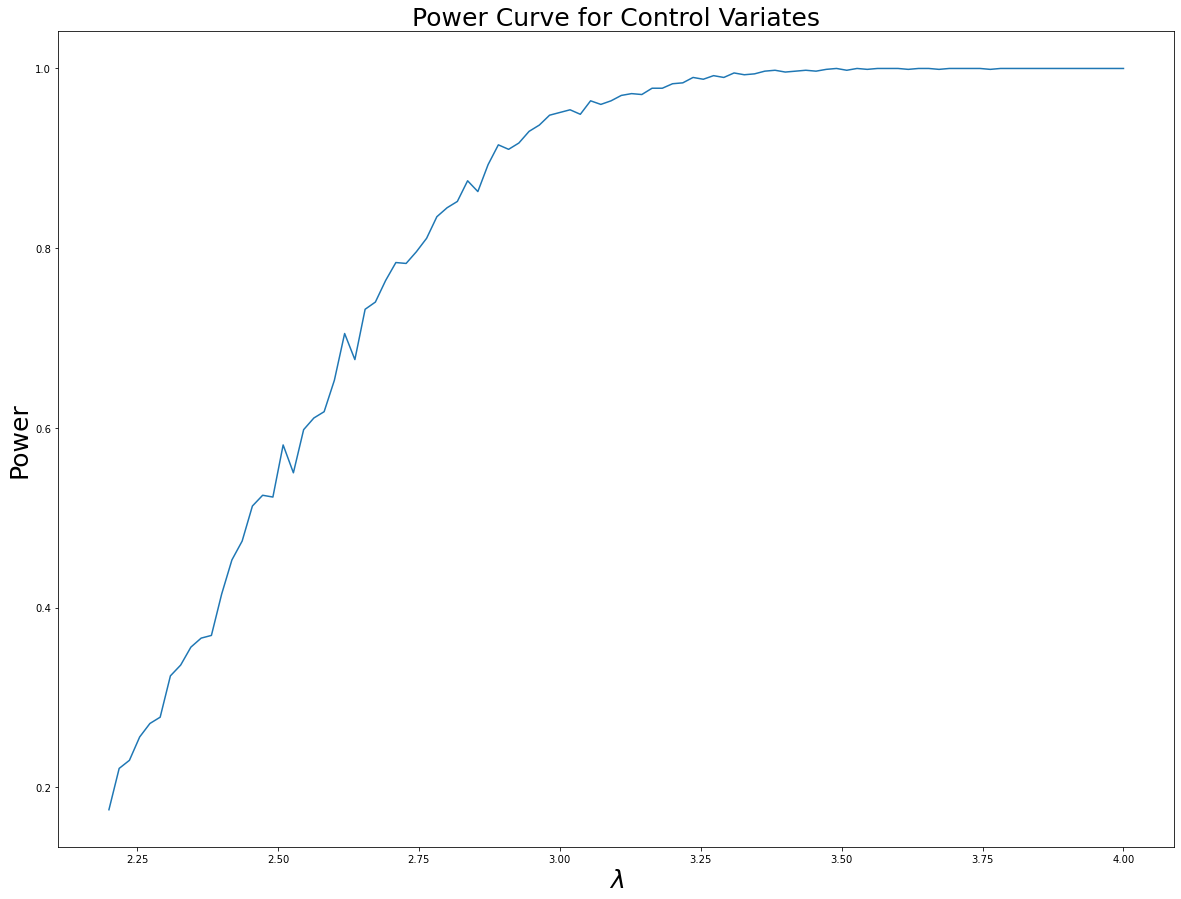

In [51]:
plt.figure(figsize=(20,15))
plt.plot(lambda_range,power_cv) # plot power vs lambda in range of [2.2,4]
plt.title('Power Curve for Control Variates',fontsize=25)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Power',fontsize=25)
plt.show()

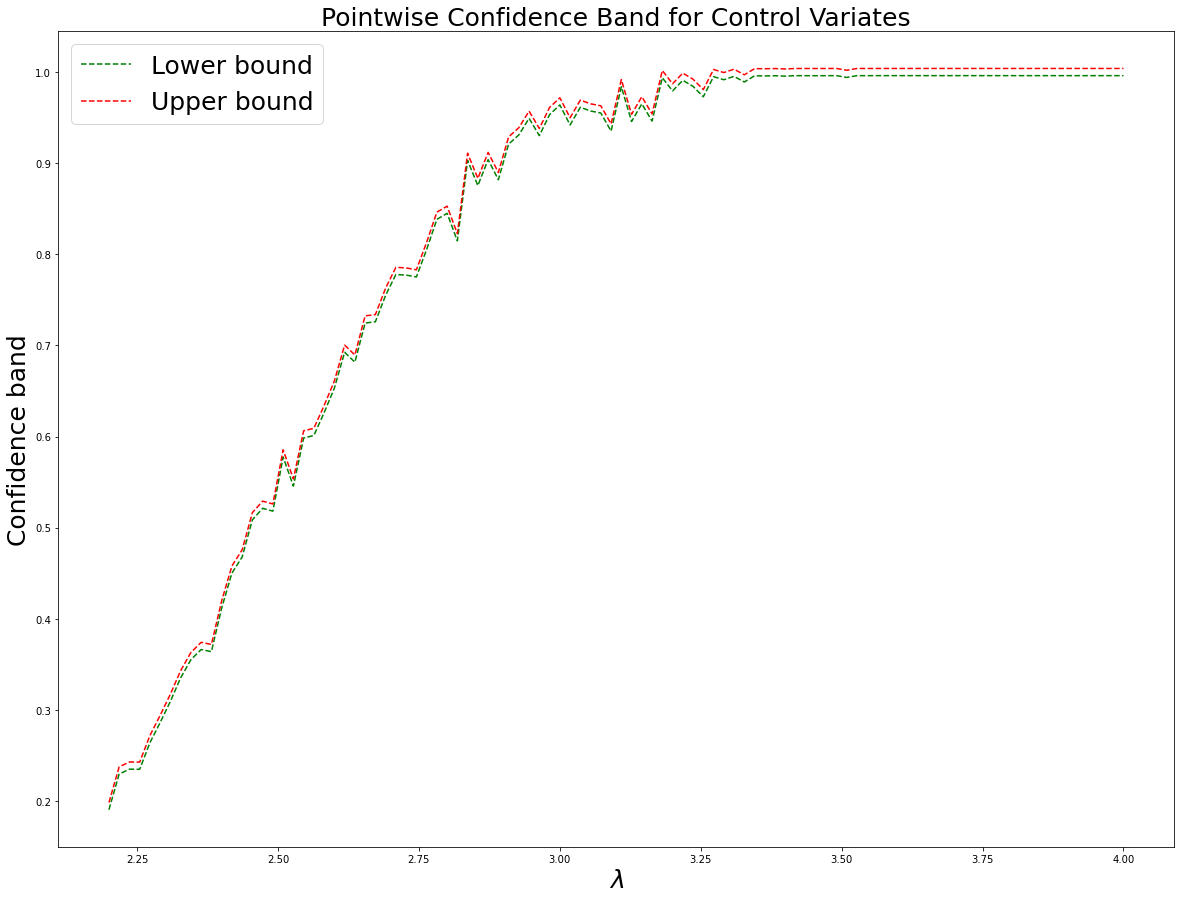

In [52]:
plt.figure(figsize=(20,15))
plt.plot(lambda_range,cv_con_lo_bound,'g--',label='Lower bound') # plot the lower bound 
plt.plot(lambda_range,cv_con_up_bound,'r--',label='Upper bound'); # plot the upper bound
plt.title('Pointwise Confidence Band for Control Variates',fontsize=25)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Confidence band',fontsize=25)
plt.legend(fontsize=25)
plt.show()

## Discussion

### The pointwise confidence bond for the Antithetic method is very tight. Also, the standard Monte Carlo has the highest bond gap. 

### Among the importance sampling strategies, the unstandardized importance sampling shows big bonds specially for $\lambda>3.2$. The reason can be unstandardized weights, $w^*=\frac{f(x_i)}{g(x_i)}$, which is larger than 1 for $\lambda>3.2$. Therefore, the variance of the interval increases. Whereas, standardized and control variate sampling methods have the same performance and their bond gap is very small for  λ ∈ [2.2, 4]. 